# Embedding of Metabolights studies
How similar are studies based on the metadata?

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer, BertModel
import torch
import pandas as pd

Start with a simple example from COVID studies. How to encode string and free text data?

In [5]:
covid_subset = pd.read_csv('COVID_studies.csv')

In [3]:
covid_subset.head(5)

,_id,_index,_score,allCountries.code,allCountries.code.keyword,allCountries.name,allCountries.name.keyword,assayFiles.assayTechnique.main_technique,assayFiles.assayTechnique.main_technique.keyword,assayFiles.assayTechnique.name,...,submitters.status,submitters.status.keyword,submitters.user_name,submitters.user_name.keyword,tags,tags.keyword,targetedStatus,title,title.keyword,updateDate
0,MTBLS2542,study,8.740,CN,CN,China,China,"MS, MS, MS, MS","MS, MS, MS, MS","LC-MS, LC-MS, LC-MS, LC-MS",...,ACTIVE,ACTIVE,chendongsheng@genomics.cn,chendongsheng@genomics.cn,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,The trans-omics landscape of COVID-19,The trans-omics landscape of COVID-19,"Jan 26, 2023 @ 00:00:00.000"
1,MTBLS2291,study,8.628,IN,IN,India,India,MS,MS,LC-MS,...,ACTIVE,ACTIVE,194303005@iitb.ac.in,194303005@iitb.ac.in,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,Metabolome and exposome profiling of the biosp...,Metabolome and exposome profiling of the biosp...,"Jan 13, 2022 @ 00:00:00.000"
2,MTBLS2349,study,8.628,IN,IN,India,India,MS,MS,LC-MS,...,ACTIVE,ACTIVE,194303005@iitb.ac.in,194303005@iitb.ac.in,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,Metabolome and exposome profiling of the biosp...,Metabolome and exposome profiling of the biosp...,"Jan 13, 2022 @ 00:00:00.000"
3,MTBLS1987,study,8.383,US,US,United States,United States,"MS, MS, MS, MS","MS, MS, MS, MS","LC-MS, LC-MS, LC-MS, LC-MS",...,ACTIVE,ACTIVE,yupingcai2012@gmail.com,yupingcai2012@gmail.com,UPLC-QTOF-MS,UPLC-QTOF-MS,untargeted,Kynurenic acid underlies sex-specific immune r...,Kynurenic acid underlies sex-specific immune r...,"Sep 8, 2020 @ 01:00:00.000"
4,MTBLS2224,study,8.357,CN,CN,China,China,"MS, MS, MS","MS, MS, MS","GC-MS, LC-MS, LC-MS",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
covid_subset = covid_subset.fillna('')

In [7]:

# Load your DataFrame
df = covid_subset


In [91]:
df.shape

(21, 239)

In [142]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to obtain embeddings for a text
def get_text_embedding(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    # Get the model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings from the model outputs
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling of token embeddings
    return embeddings


# Select the text columns you want to embed
text_columns = ['allCountries.code', 'targetedStatus', 'assayFiles.assayTechnique.main_technique.keyword','sampleFile.organisms.term' ]  # Example columns
# text_columns = ['allCountries.code', 'assayFiles.assayTechnique.main_technique.keyword']  

embeddings_all = []
# Iterate over text columns and obtain embeddings
for column in text_columns:
    # Obtain embeddings for each row in the column
    embeddings_list = []
    for text in df[column]:
        embeddings = get_text_embedding(text)
        embeddings_list.append(embeddings)
    # Concatenate embeddings to create a single tensor
    embeddings_tensor = torch.cat(embeddings_list, dim=0)
    # Add embeddings as new columns to the DataFrame
    for i in range(embeddings_tensor.shape[1]):
        # df[f'{column}_embedding_{i}'] = embeddings_tensor[:, i].numpy()
        embeddings_all.append(embeddings_tensor[:, i].numpy())



In [143]:
embeddings_df = pd.DataFrame(embeddings_all).T

In [95]:
df.head()

,_id,_index,_score,allCountries.code,allCountries.code.keyword,allCountries.name,allCountries.name.keyword,assayFiles.assayTechnique.main_technique,assayFiles.assayTechnique.main_technique.keyword,assayFiles.assayTechnique.name,...,submitters.status,submitters.status.keyword,submitters.user_name,submitters.user_name.keyword,tags,tags.keyword,targetedStatus,title,title.keyword,updateDate
0,MTBLS2542,study,8.740,CN,CN,China,China,"MS, MS, MS, MS","MS, MS, MS, MS","LC-MS, LC-MS, LC-MS, LC-MS",...,ACTIVE,ACTIVE,chendongsheng@genomics.cn,chendongsheng@genomics.cn,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,The trans-omics landscape of COVID-19,The trans-omics landscape of COVID-19,"Jan 26, 2023 @ 00:00:00.000"
1,MTBLS2291,study,8.628,IN,IN,India,India,MS,MS,LC-MS,...,ACTIVE,ACTIVE,194303005@iitb.ac.in,194303005@iitb.ac.in,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,Metabolome and exposome profiling of the biosp...,Metabolome and exposome profiling of the biosp...,"Jan 13, 2022 @ 00:00:00.000"
2,MTBLS2349,study,8.628,IN,IN,India,India,MS,MS,LC-MS,...,ACTIVE,ACTIVE,194303005@iitb.ac.in,194303005@iitb.ac.in,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,Metabolome and exposome profiling of the biosp...,Metabolome and exposome profiling of the biosp...,"Jan 13, 2022 @ 00:00:00.000"
3,MTBLS1987,study,8.383,US,US,United States,United States,"MS, MS, MS, MS","MS, MS, MS, MS","LC-MS, LC-MS, LC-MS, LC-MS",...,ACTIVE,ACTIVE,yupingcai2012@gmail.com,yupingcai2012@gmail.com,UPLC-QTOF-MS,UPLC-QTOF-MS,untargeted,Kynurenic acid underlies sex-specific immune r...,Kynurenic acid underlies sex-specific immune r...,"Sep 8, 2020 @ 01:00:00.000"
4,MTBLS2224,study,8.357,CN,CN,China,China,"MS, MS, MS","MS, MS, MS","GC-MS, LC-MS, LC-MS",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-0.046801,-0.277752,-0.124927,-0.129843,0.028515,-0.006654,0.173481,-0.004920,-0.034172,-0.339261,...,0.114999,0.239888,0.065370,0.001315,0.004597,-0.472193,-0.462036,-0.505633,-0.199777,0.358122
1,-0.010469,-0.348870,-0.399061,-0.106116,0.061948,-0.108716,0.160446,-0.023786,-0.008437,-0.303205,...,0.333807,0.104023,0.311481,0.110723,-0.170469,-0.137501,-0.379697,-0.459105,-0.199951,0.350976
2,-0.010469,-0.348870,-0.399061,-0.106116,0.061948,-0.108716,0.160446,-0.023786,-0.008437,-0.303205,...,0.333807,0.104023,0.311481,0.110723,-0.170469,-0.137501,-0.379697,-0.459105,-0.199951,0.350976
3,0.334465,-0.007787,0.002369,0.074936,-0.229027,-0.180959,0.387281,-0.085231,0.220397,-0.259655,...,0.112661,0.210983,0.160912,0.075254,-0.055923,-0.476646,-0.502867,-0.429431,-0.110077,0.389159
4,-0.046801,-0.277752,-0.124927,-0.129843,0.028515,-0.006654,0.173481,-0.004920,-0.034172,-0.339261,...,0.210963,0.203249,0.109061,0.042101,-0.026323,-0.457803,-0.489346,-0.552777,-0.272056,0.361899


In [144]:
embedding_scaled = StandardScaler().set_output(transform="pandas").fit_transform(embeddings_df)

In [145]:
embedding_pca = PCA(2).fit_transform(embedding_scaled)
embedding_df = pd.DataFrame(embedding_pca)
embedding_df = pd.concat([embedding_df, covid_subset], axis=1)

In [138]:
embedding_df.head()

,0,1,_id,_index,_score,allCountries.code,allCountries.code.keyword,allCountries.name,allCountries.name.keyword,assayFiles.assayTechnique.main_technique,...,submitters.status,submitters.status.keyword,submitters.user_name,submitters.user_name.keyword,tags,tags.keyword,targetedStatus,title,title.keyword,updateDate
0,-19.268486,4.809451,MTBLS2542,study,8.740,CN,CN,China,China,"MS, MS, MS, MS",...,ACTIVE,ACTIVE,chendongsheng@genomics.cn,chendongsheng@genomics.cn,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,The trans-omics landscape of COVID-19,The trans-omics landscape of COVID-19,"Jan 26, 2023 @ 00:00:00.000"
1,-21.947226,-3.750870,MTBLS2291,study,8.628,IN,IN,India,India,MS,...,ACTIVE,ACTIVE,194303005@iitb.ac.in,194303005@iitb.ac.in,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,Metabolome and exposome profiling of the biosp...,Metabolome and exposome profiling of the biosp...,"Jan 13, 2022 @ 00:00:00.000"
2,-21.947222,-3.750882,MTBLS2349,study,8.628,IN,IN,India,India,MS,...,ACTIVE,ACTIVE,194303005@iitb.ac.in,194303005@iitb.ac.in,UPLC-LTQ-MS/MS,UPLC-LTQ-MS/MS,untargeted,Metabolome and exposome profiling of the biosp...,Metabolome and exposome profiling of the biosp...,"Jan 13, 2022 @ 00:00:00.000"
3,-19.747583,-8.823310,MTBLS1987,study,8.383,US,US,United States,United States,"MS, MS, MS, MS",...,ACTIVE,ACTIVE,yupingcai2012@gmail.com,yupingcai2012@gmail.com,UPLC-QTOF-MS,UPLC-QTOF-MS,untargeted,Kynurenic acid underlies sex-specific immune r...,Kynurenic acid underlies sex-specific immune r...,"Sep 8, 2020 @ 01:00:00.000"
4,10.327870,34.427505,MTBLS2224,study,8.357,CN,CN,China,China,"MS, MS, MS",...,,,,,,,,,,


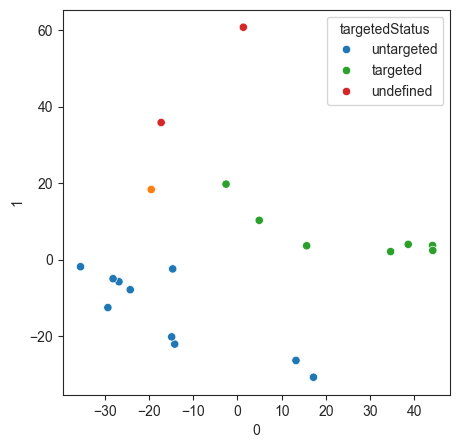

In [149]:
sns.set_style('ticks')
plt.figure(figsize=(5,5))
sns.scatterplot(
    data=embedding_df,
    x=0,
    y=1,
    hue='targetedStatus'
)
plt.show()

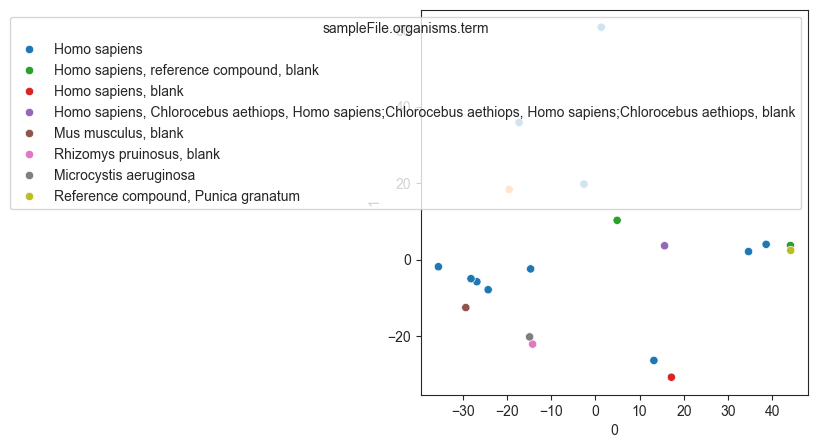

In [150]:
sns.set_style('ticks')
plt.figure(figsize=(5,5))
sns.scatterplot(
    data=embedding_df,
    x=0,
    y=1,
    hue='sampleFile.organisms.term'
)
plt.show()

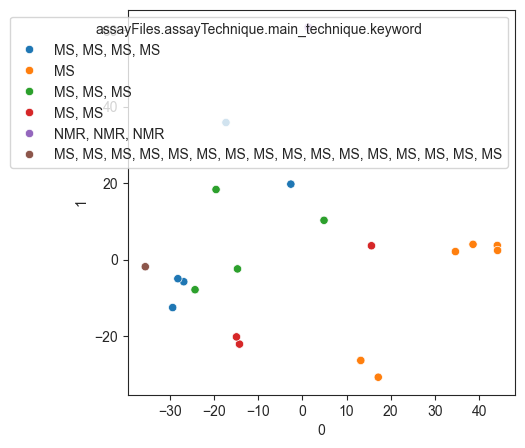

In [151]:
sns.set_style('ticks')
plt.figure(figsize=(5,5))
sns.scatterplot(
    data=embedding_df,
    x=0,
    y=1,
    hue='assayFiles.assayTechnique.main_technique.keyword'
)
plt.show()

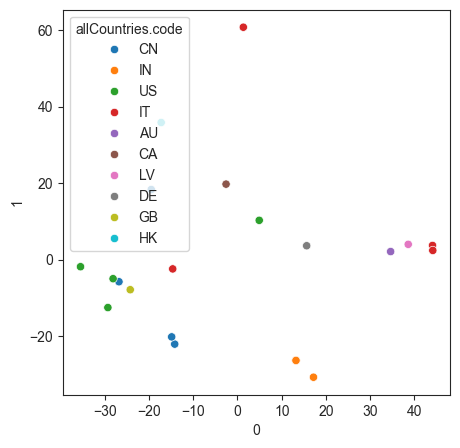

In [152]:
sns.set_style('ticks')
plt.figure(figsize=(5,5))
sns.scatterplot(
    data=embedding_df,
    x=0,
    y=1,
    hue='allCountries.code'
)
plt.show()

## Embedding by study title

In [8]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to obtain embeddings for a text
def get_text_embedding(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    # Get the model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings from the model outputs
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling of token embeddings
    return embeddings


# Select the text columns you want to embed
text_columns = ['title']  # Example columns
# text_columns = ['allCountries.code', 'assayFiles.assayTechnique.main_technique.keyword']  

embeddings_all = []
# Iterate over text columns and obtain embeddings
for column in text_columns:
    # Obtain embeddings for each row in the column
    embeddings_list = []
    for text in df[column]:
        embeddings = get_text_embedding(text)
        embeddings_list.append(embeddings)
    # Concatenate embeddings to create a single tensor
    embeddings_tensor = torch.cat(embeddings_list, dim=0)
    # Add embeddings as new columns to the DataFrame
    for i in range(embeddings_tensor.shape[1]):
        # df[f'{column}_embedding_{i}'] = embeddings_tensor[:, i].numpy()
        embeddings_all.append(embeddings_tensor[:, i].numpy())


In [7]:
embeddings_df = pd.DataFrame(embeddings_all).T
embedding_scaled = StandardScaler().set_output(transform="pandas").fit_transform(embeddings_df)


In [9]:
embedding_pca = PCA(2).fit_transform(embedding_scaled)
embedding_df = pd.DataFrame(embedding_pca)
embedding_df = pd.concat([embedding_df, covid_subset], axis=1)

In [23]:
df_iris=sns.load_dataset("iris") 


In [24]:
df_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


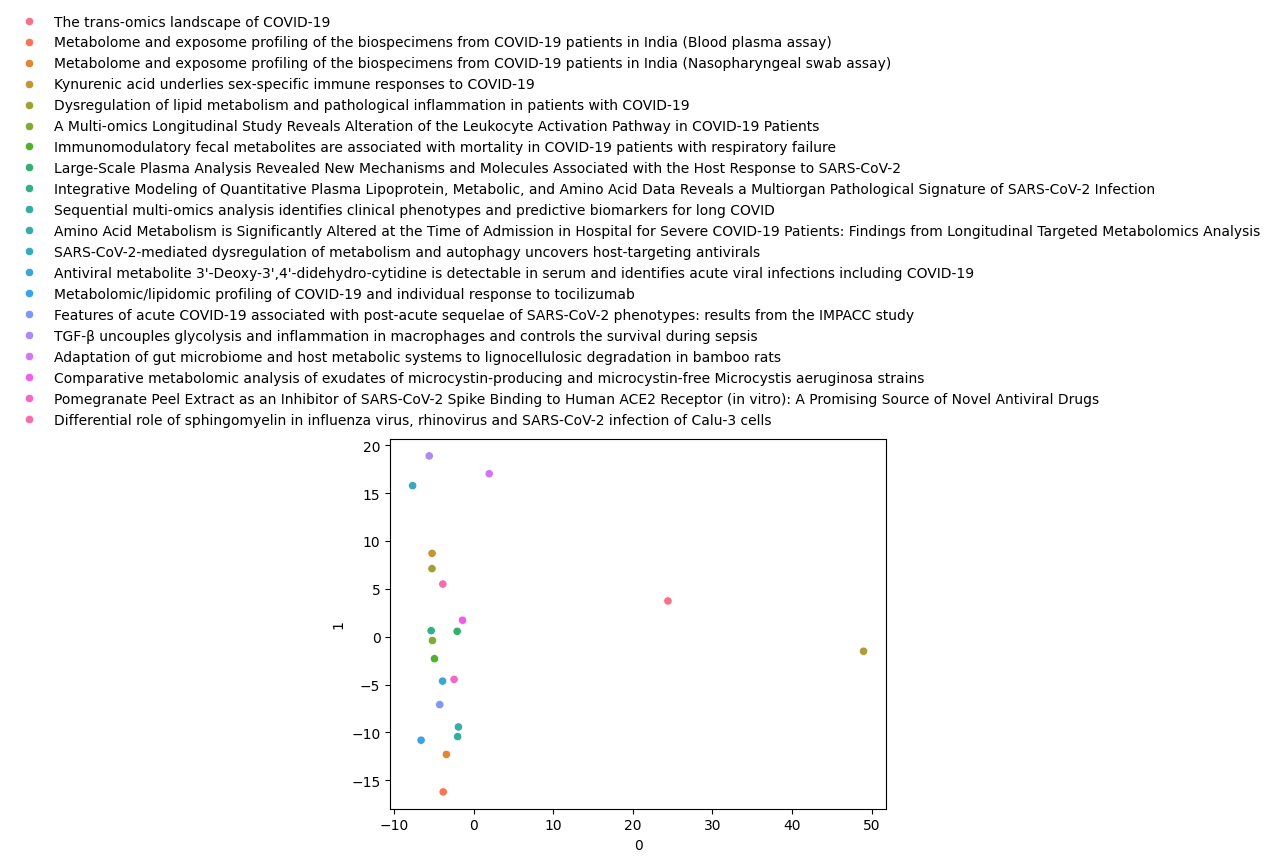

In [32]:
p = sns.scatterplot(
    data=embedding_df,
    x=0,
    y=1,
    hue='title'
)
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=False,
)


In [34]:
all_titles = pd.read_csv('study_titles.csv')

In [23]:
all_titles.head()

,title,assayFiles.assayTechnique.technique
0,Inferring metabolic mechanisms of interaction ...,NMR
1,Gluconeogenesis using glycerol as a substrate ...,LC-MS
2,High metabolic variation for seaweeds in respo...,"LC-MS, LC-MS, LC-MS"
3,Metabolic consequences of cobalamin scarcity i...,"LC-MS, LC-MS, LC-MS"
4,Chemical Diversity and Classification of Secon...,LC-MS


In [36]:
all_titles['assayFiles.assayTechnique.technique'] = [x.split(',')[0] for x in all_titles['assayFiles.assayTechnique.technique']]

In [37]:
all_titles

,title,assayFiles.assayTechnique.technique
0,Inferring metabolic mechanisms of interaction ...,NMR
1,Gluconeogenesis using glycerol as a substrate ...,LC-MS
2,High metabolic variation for seaweeds in respo...,LC-MS
3,Metabolic consequences of cobalamin scarcity i...,LC-MS
4,Chemical Diversity and Classification of Secon...,LC-MS
...,...,...
1461,Exometabolomic profiling of bacterial strains ...,LC-MS
1462,An Unbiased Lipid Phenotyping Approach To Stud...,Direct Injection
1463,MaHPIC Experiment 03: Metabolomics from Macaca...,LC-MS
1464,MaHPIC Experiment 23: Metabolomics from Macaca...,LC-MS


Embed all titles

In [40]:
text_columns = ['title', 'assayFiles.assayTechnique.technique']

In [41]:

embeddings_all = []
# Iterate over text columns and obtain embeddings
for column in text_columns:
    # Obtain embeddings for each row in the column
    embeddings_list = []
    for text in all_titles[column]:
        embeddings = get_text_embedding(text)
        embeddings_list.append(embeddings)
    # Concatenate embeddings to create a single tensor
    embeddings_tensor = torch.cat(embeddings_list, dim=0)
    # Add embeddings as new columns to the DataFrame
    for i in range(embeddings_tensor.shape[1]):
        # df[f'{column}_embedding_{i}'] = embeddings_tensor[:, i].numpy()
        embeddings_all.append(embeddings_tensor[:, i].numpy())


In [42]:
embeddings_df = pd.DataFrame(embeddings_all).T

In [43]:
embeddings_df.shape

(1466, 1536)

In [44]:
embedding_scaled = StandardScaler().set_output(transform="pandas").fit_transform(embeddings_df)

In [45]:
embedding_pca = PCA(2).fit_transform(embedding_scaled)
embedding_df = pd.DataFrame(embedding_pca)
embedding_df = pd.concat([embedding_df, all_titles], axis=1)

In [46]:
embedding_df

,0,1,title,assayFiles.assayTechnique.technique
0,45.276051,-18.770470,Inferring metabolic mechanisms of interaction ...,NMR
1,-11.366277,-3.702346,Gluconeogenesis using glycerol as a substrate ...,LC-MS
2,-11.180511,-1.729891,High metabolic variation for seaweeds in respo...,LC-MS
3,-10.702517,-2.833742,Metabolic consequences of cobalamin scarcity i...,LC-MS
4,-11.267400,-1.866240,Chemical Diversity and Classification of Secon...,LC-MS
...,...,...,...,...
1461,-10.725620,-1.885767,Exometabolomic profiling of bacterial strains ...,LC-MS
1462,31.554003,48.534523,An Unbiased Lipid Phenotyping Approach To Stud...,Direct Injection
1463,-10.717454,-2.467453,MaHPIC Experiment 03: Metabolomics from Macaca...,LC-MS
1464,-10.601282,-2.894400,MaHPIC Experiment 23: Metabolomics from Macaca...,LC-MS


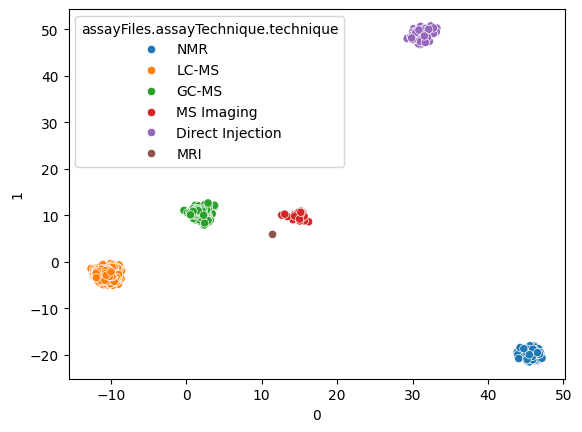

In [47]:
p = sns.scatterplot(
    data=embedding_df,
    x=0,
    y=1,
    hue='assayFiles.assayTechnique.technique'
)

In [48]:
import plotly.express as px


In [49]:
fig = px.scatter(embedding_df,
    x=0,
    y=1,
    hover_data=['title'],
    color='assayFiles.assayTechnique.technique')
fig.show()

## Look at chromatography types
Upset plot

In [53]:
chrom = pd.read_csv('MetaboLights_assays.csv')

In [42]:
chrom.head()

,title,tags,assayTechniques.technique
0,Inferring metabolic mechanisms of interaction ...,NMR,NMR
1,Gluconeogenesis using glycerol as a substrate ...,LC-LTQ-MS,LC-MS
2,High metabolic variation for seaweeds in respo...,UPLC-QTOF-MS,LC-MS
3,Metabolic consequences of cobalamin scarcity i...,LC-LTQ-MS/MS,LC-MS
4,Chemical Diversity and Classification of Secon...,UPLC-QTOF-MS,LC-MS


In [43]:
chrom['assayTechniques.technique'].value_counts()

assayTechniques.technique
LC-MS                                         942
GC-MS                                         184
NMR                                           155
Direct Injection                               62
GC-MS, LC-MS                                   29
LC-MS, GC-MS                                   27
MS Imaging                                     25
LC-MS, Direct Injection                         7
Direct Injection, LC-MS                         7
LC-MS, NMR                                      7
NMR, LC-MS                                      4
NMR, GC-MS                                      3
LC-MS, MS Imaging                               2
MRI                                             1
LC-MS, GC-MS, NMR                               1
MS Imaging, LC-MS, GC-MS, Direct Injection      1
GC-MS, Direct Injection                         1
Direct Injection, MS Imaging                    1
NMR, LC-MS, GC-MS                               1
Direct Injection, GC-MS 

In [18]:
assay_technique = chrom.groupby('assayTechniques.technique').size()

<Axes: ylabel='assayTechniques.technique'>

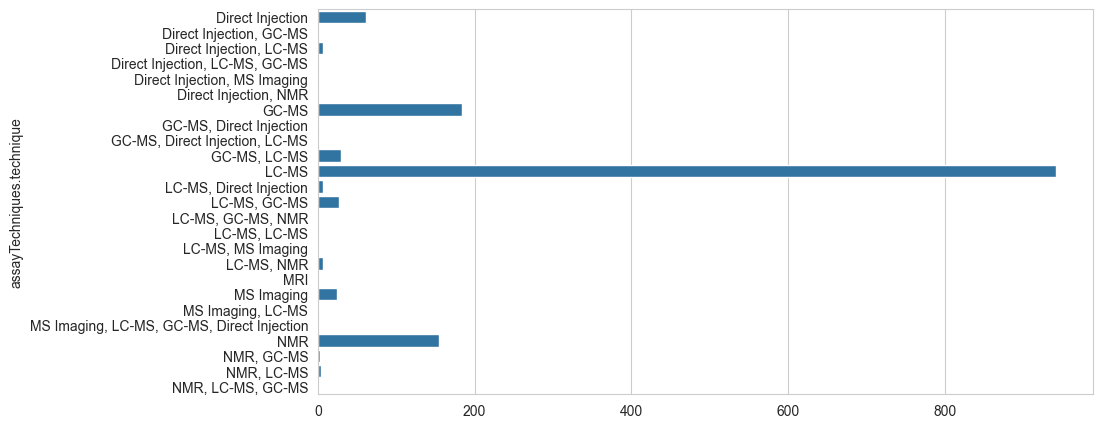

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.barplot(
    data=assay_technique,
    orient='h'
)

In [13]:
import upsetplot
from upsetplot import plot

In [12]:
chrom.groupby('assayTechniques.technique').size()

assayTechniques.technique
Direct Injection                               62
Direct Injection, GC-MS                         1
Direct Injection, LC-MS                         7
Direct Injection, LC-MS, GC-MS                  1
Direct Injection, MS Imaging                    1
Direct Injection, NMR                           1
GC-MS                                         184
GC-MS, Direct Injection                         1
GC-MS, Direct Injection, LC-MS                  1
GC-MS, LC-MS                                   29
LC-MS                                         942
LC-MS, Direct Injection                         7
LC-MS, GC-MS                                   27
LC-MS, GC-MS, NMR                               1
LC-MS, LC-MS                                    1
LC-MS, MS Imaging                               2
LC-MS, NMR                                      7
MRI                                             1
MS Imaging                                     25
MS Imaging, LC-MS       

In [54]:
chrom['assayTechniques.technique'] = chrom['assayTechniques.technique'].str.split(', ')
chrom_expanded = chrom.explode('assayTechniques.technique')

In [65]:
chrom_tags = chrom
chrom_tags['tags'] = chrom_tags['tags'].str.split(', ')
chrom_tags_expanded = chrom_tags.explode('tags')

In [68]:
chrom_tags_expanded['tags'].value_counts()

tags
UPLC-LTQ-MS/MS                    210
UPLC-QTOF-MS/MS                   167
NMR                               159
UPLC-QTOF-MS                      151
UPLC-LTQ-MS                       103
                                 ... 
PTR-MS                              1
LC-MS simulation                    1
3D MALDI imaging MS simulation      1
SPE-IMS-MS                          1
SPME-TQ-MS                          1
Name: count, Length: 113, dtype: int64

In [55]:
chrom_expanded

,title,tags,assayTechniques.technique
0,Inferring metabolic mechanisms of interaction ...,NMR,NMR
1,Gluconeogenesis using glycerol as a substrate ...,LC-LTQ-MS,LC-MS
2,High metabolic variation for seaweeds in respo...,UPLC-QTOF-MS,LC-MS
3,Metabolic consequences of cobalamin scarcity i...,LC-LTQ-MS/MS,LC-MS
4,Chemical Diversity and Classification of Secon...,UPLC-QTOF-MS,LC-MS
...,...,...,...
1461,Exometabolomic profiling of bacterial strains ...,HPLC-QTOF-MS,LC-MS
1462,An Unbiased Lipid Phenotyping Approach To Stud...,DI-LTQ-MS,Direct Injection
1463,MaHPIC Experiment 03: Metabolomics from Macaca...,HPLC-LTQ-MS,LC-MS
1464,MaHPIC Experiment 23: Metabolomics from Macaca...,HPLC-LTQ-MS,LC-MS


In [56]:
chrom_expanded['assayTechniques.technique'].value_counts()

assayTechniques.technique
LC-MS               1033
GC-MS                250
NMR                  172
Direct Injection      83
MS Imaging            30
MRI                    1
Name: count, dtype: int64

Text(0.5, 0, 'Number of studies using x assay')

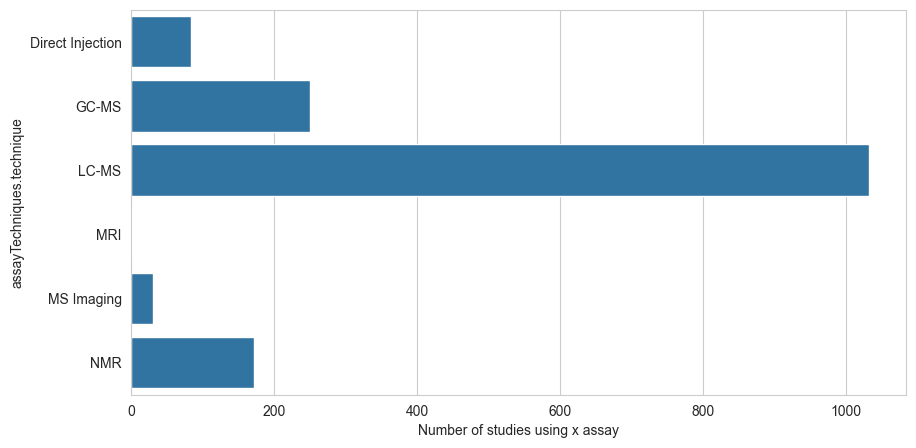

In [59]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.barplot(
    data=chrom_expanded.groupby('assayTechniques.technique').size(),
    orient='h'
)
plt.xlabel('Number of studies using x assay')

Text(0.5, 0, 'Number of studies using x assay')

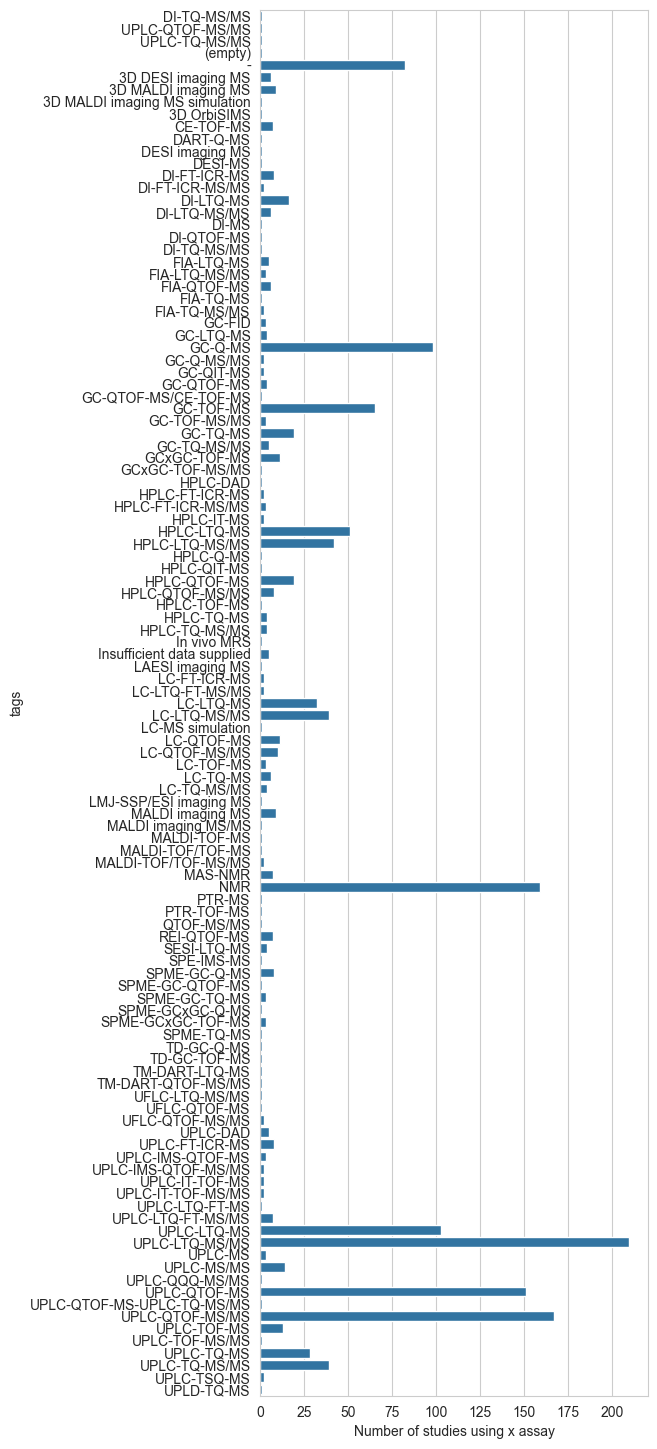

In [71]:
sns.set_style('whitegrid')
plt.figure(figsize=(5, 18))
sns.barplot(
    data=chrom_tags_expanded.groupby('tags').size(),
    orient='h'
)
plt.xlabel('Number of studies using x assay')

In [73]:
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

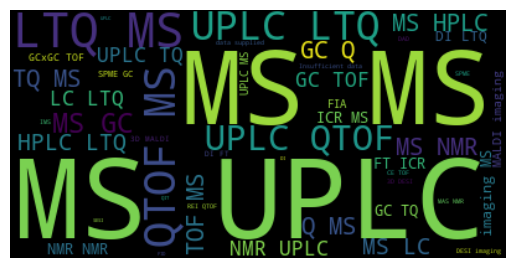

In [76]:
wordcloud = WordCloud().generate(chrom_tags_expanded['tags'].str.cat(sep=' '))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

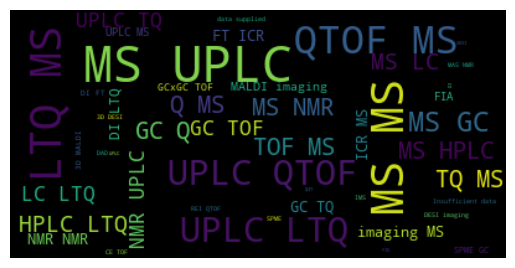

In [78]:
wordcloud = WordCloud(max_font_size=40).generate(chrom_tags_expanded['tags'].str.cat(sep=' '))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [63]:
chrom_expanded.groupby(['assayTechniques.technique']).size()

assayTechniques.technique
Direct Injection      83
GC-MS                250
LC-MS               1033
MRI                    1
MS Imaging            30
NMR                  172
dtype: int64

In [14]:
plot(chrom.groupby('assayTechniques.technique').size())

AttributeError: 'Index' object has no attribute 'levels'